In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Defining data file paths
DEM_PATH_1955  = "/home/matthaeus/Downloads/dem_morteratsch_1955.txt"
MASK_PATH_1955 = "/home/matthaeus/Downloads/glacier_mask_1955.txt"
DEM_PATH_2008  = "/home/matthaeus/Downloads/dem_morteratsch_2008.txt"
MASK_PATH_2008 = "/home/matthaeus/Downloads/glacier_mask_2008.txt"

In [3]:
def load_metadata(file_path):
    with open(file_path, 'r') as infile:
        meta_data_dict = {}
        for line_idx in range(6):
            descriptor, value = infile.readline().split()
            meta_data_dict[descriptor.lower()] = value
        return meta_data_dict
    
def load_data(file_path):
    return np.genfromtxt(file_path, skip_header=6)

In [4]:
# Loading all data
meta_data_1955 = load_metadata(DEM_PATH_1955)
dem_data_1955 = load_data(DEM_PATH_1955)
rock_mask_1955 = load_data(MASK_PATH_1955)
meta_data_2008 = load_metadata(DEM_PATH_2008)
dem_data_2008 = load_data(DEM_PATH_2008)
rock_mask_2008 = load_data(MASK_PATH_2008)

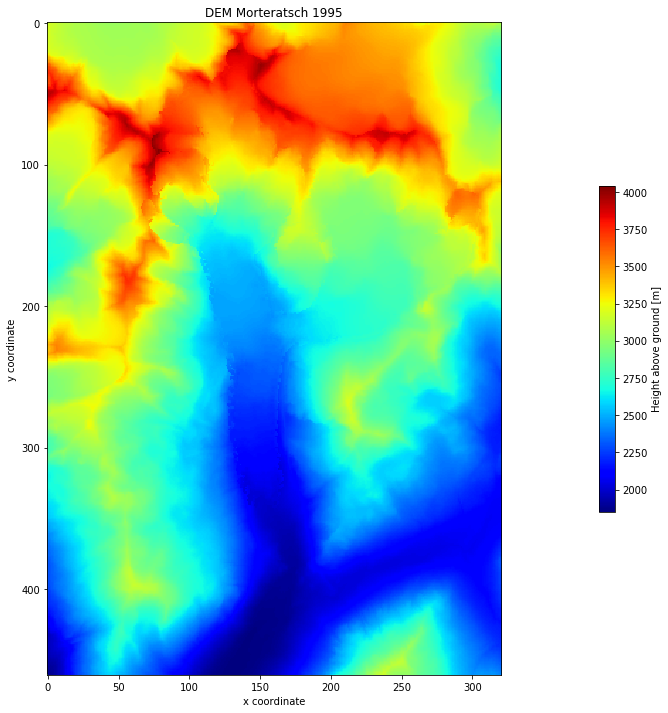

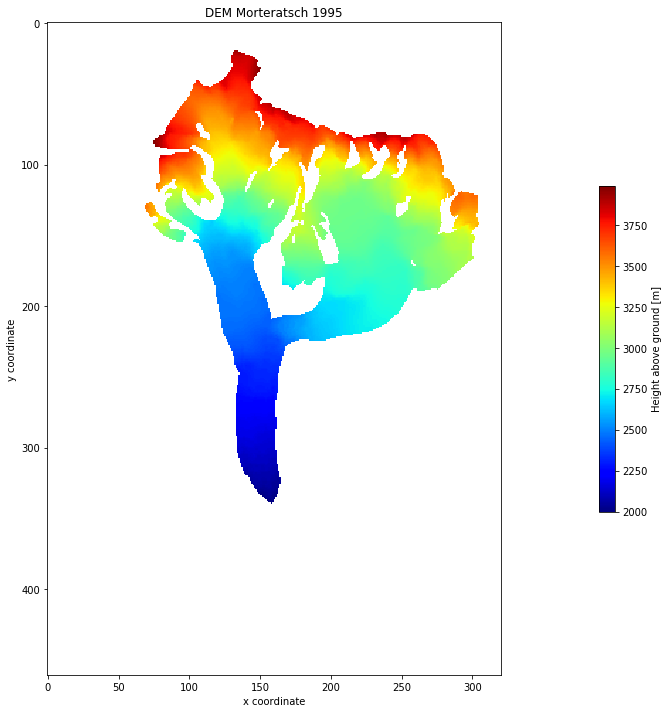

In [5]:
def mask_data(dem_data, mask, fill_masked_val='nan'):
    data = dem_data.copy()
    mask_inv = 1 - mask
    np.putmask(data, mask_inv, 0)
    data[data == 0] = fill_masked_val
    return data
    
def plot_height_map(data, title='', cb_label='', mask=None):
    data = data.copy()
    if mask is not None:
        data = mask_data(data, mask)
    flipped = np.flipud(data)
    fig, ax = plt.subplots(figsize=(35, 12))
    plot = ax.imshow(flipped, cmap='jet')
    ax.set_xlabel('x coordinate')
    ax.set_ylabel('y coordinate')
    ax.set_title(title)
    fig.colorbar(plot, shrink=0.5, aspect=20, label=cb_label)
    plt.show()

# Plot height maps
plot_height_map(dem_data_1955, title='DEM Morteratsch 1995', cb_label='Height above ground [m]')
plot_height_map(dem_data_1955, mask=rock_mask_1955, title='DEM Morteratsch 1995', cb_label='Height above ground [m]')
# plot_height_map(dem_data_2008, title='DEM Morteratsch 2008')
# plot_height_map(dem_data_2008, mask=rock_mask, title='DEM Morteratsch 2008')

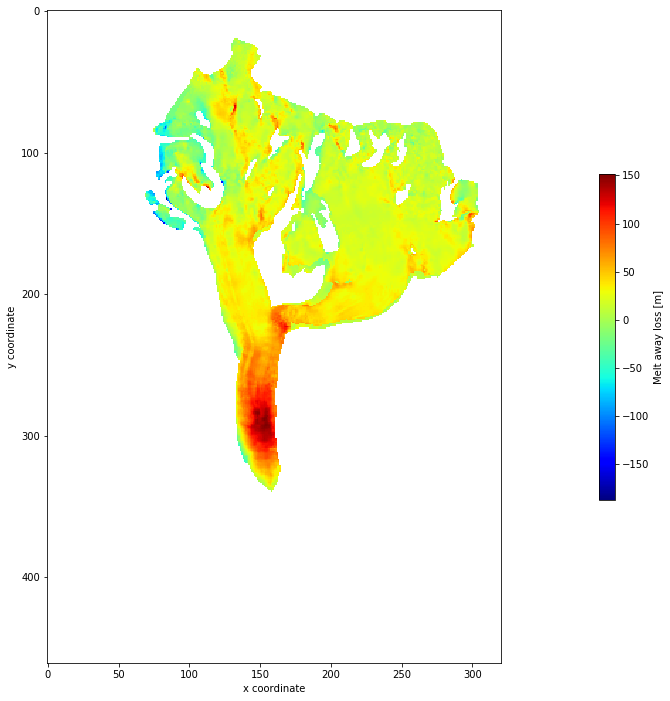

In [6]:
# Plot height difference with 2008 mask applied
difference = mask_data(dem_data_1955, rock_mask_1955, fill_masked_val=0) \
           - mask_data(dem_data_2008, rock_mask_1955, fill_masked_val=0)
plot_height_map(difference, mask=rock_mask_1955, cb_label='Melt away loss [m]')

In [7]:
# trapz2d functino taken from the web...
def trapz2d(z, x=None,y=None,dx=25,dy=25):
    """Integrates a regularly spaced 2D grid using the composite trapezium rule. 
    Arguments
    ---------
       z : 2D array
       x : (optional) grid values for x (1D array)
       y : (optional) grid values for y (1D array)
       dx: if x is not supplied, set it to the x grid interval
       dy: if y is not supplied, set it to the x grid interval
    """
    import numpy as N
    
    sum = N.sum
    if x != None:
        dx = (x[-1]-x[0])/(N.shape(x)[0]-1)
    if y != None:
        dy = (y[-1]-y[0])/(N.shape(y)[0]-1)    
    
    s1 = z[0,0] + z[-1,0] + z[0,-1] + z[-1,-1]
    s2 = sum(z[1:-1,0]) + sum(z[1:-1,-1]) + sum(z[0,1:-1]) + sum(z[-1,1:-1])
    s3 = sum(z[1:-1,1:-1])
    
    return 0.25*dx*dy*(s1 + 2*s2 + 4*s3)

In [8]:
volume_1955 = trapz2d(mask_data(dem_data_1955, rock_mask_1955, fill_masked_val=0))
volume_2008 = trapz2d(mask_data(dem_data_2008, rock_mask_2008, fill_masked_val=0))
difference = dem_data_1955 - dem_data_2008
vol_decrease = trapz2d(difference)
print(f'The glacier lost {round(vol_decrease, 2)} m^3 of ice in {2008 - 1955} years.')

The glacier lost 397968706.25 m^3 of ice in 53 years.


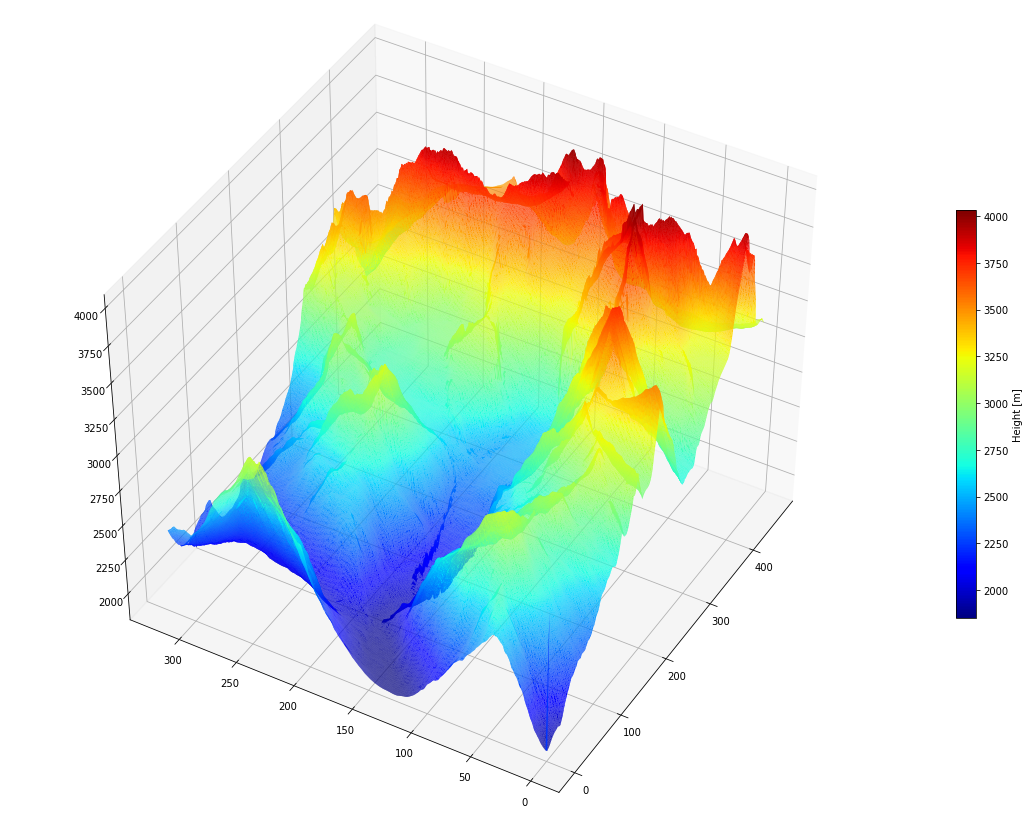

In [10]:
# library
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def plot_3d_surface(data):
    # Transform it to a long format
    data = pd.DataFrame(data)
    df=data.unstack().reset_index()
    df.columns=["X","Y","Z"]

    # And transform the old column name in something numeric
    df['X']=pd.Categorical(df['X'])
    df['X']=df['X'].cat.codes

    # Make the plot
    fig = plt.figure(figsize=(20, 15))
    ax = fig.gca(projection='3d')
    ax.view_init(45, 210)

    # to Add a color bar which maps values to colors.
    surf=ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.jet, linewidth=0.2)
    fig.colorbar(surf, shrink=0.5, aspect=20, label='Height [m]')

plot_3d_surface(dem_data_1955)